## Whether a user of LastFM would follow another user

### Data source
Downloaded it from [SNAP](https://snap.stanford.edu/data/feather-lastfm-social.html).

### Data Overview
Nodes are LastFM users from Asian countries and edges are mutual follower relationships between them. The vertex features are extracted based on the artists liked by the users. This is not a directed graph.

### Problem Statement
The original task related as mentioned in the source is to do multinomial node classification - one has to predict the location of users. This target feature was derived from the country field for each user.

Edge prediction, community detection, etc. can also be done with this data.

We plan to explore link prediction exercise based on existing links - basically, whether two users would follow each-other. The high-level idea is to consider this graph as a static graph, assuming it is not changing over time, to make the task simpler. This choice also makes it free from retraining graph embedding (which we plan to implement), as no new node will enter the graph. Otherwise we would have to take a different approach of graph embedding (using graph neural network).

If time permits then we might explore community detection on this dataset as well - cluster of users defined by their follower pattern.

### Approach

#### Explore graph attributes
Some topological attributes of the graph is to be explored first. For example, degree distribution, average degree, average clustering coefficient, closeness centrality, etc.

We may use an open source software [Gephi](https://gephi.org/users/quick-start/) to visualize this network besides using NetworkX `spring_layout`.  

#### Problem formulation
One approach for link prediction problem is to remove some edges randomly from the graph and attempt to predict them. Or, maybe predict top *n* edges and check if they include the removed edges.

#### Possible approaches
We plan to implement multiple approaches to predict a link.  

1. *Adamic-Adar index*: This is a descriptive based metric that assigns large weights to common neighbors of u and v which themselves have few neighbors (weights rare features
more heavily). This metric was shown to perform relatively well among other descriptive metrics.

2. *Graph Embedding*: We also plan to train an embedding for each node, and then use the embedding vector to find the closest (in Euclidean term) node on the embedding space. This approach uses adjacency matrix to define similar nodes.  
    * We have referred to the [Stanford CS224](https://web.stanford.edu/class/cs224w/) course page and their homework [Colab1](https://colab.research.google.com/drive/1dlmOgok0sYviimGvPMfekz16vSQkPFWy?usp=sharing) to train an embedding on an undirected graph. We will use this reference to develop an embedding.

3. *Variations of embedding approaches*:
    * We will explore `Node2Vec` and `DeepWalk` approaches of graph embeddings as well. These approaches are based on random walk starting at a source node and they define similarity based on the nodes that appear more often in multiple random walks originated from same source.
    * These two variations work for undirected graph, but they are not designed to work on directed graph. Our dataset is undirected, hence it can be implemented.

In [1]:
import zipfile, requests, io
import numpy as np
import pandas as pd
import json
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
import random
import community
from tqdm.notebook import tqdm
from copy import deepcopy
from networkx.algorithms.community import greedy_modularity_communities, modularity

import torch
import torch.nn as nn
from sklearn.manifold import TSNE
from sklearn.metrics import precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression

print(torch.__version__)

2.0.0+cu118


## Read graph data

In [2]:
r = requests.get("https://snap.stanford.edu/data/lastfm_asia.zip")
zf = zipfile.ZipFile(io.BytesIO(r.content))

# zf.filelist

# read followers
follower = pd.read_csv(zf.open('lasftm_asia/lastfm_asia_edges.csv'))
display(follower.head())

# read target
target = pd.read_csv(zf.open('lasftm_asia/lastfm_asia_target.csv'))
display(target.head())

# read features
with zf.open('lasftm_asia/lastfm_asia_features.json') as myfile:
    data=myfile.read()
features = json.loads(data)
len(features[list(features.keys())[0]])

# label for each node
labels = dict(zip(target['id'], target['target']))

,node_1,node_2
0,0,747
1,1,4257
2,1,2194
3,1,580
4,1,6478


,id,target
0,0,8
1,1,17
2,2,3
3,3,17
4,4,5


In [3]:
follower['node_1'].value_counts()
follower[follower['node_1']==3388]

,node_1,node_2
19254,3388,4785


In [4]:
# Create NX graph from the dataset
G = nx.from_pandas_edgelist(follower, "node_1", "node_2")

In [5]:
# Sanity checks
print(nx.is_directed(G))
print(G.edges(3388))
print(nx.is_connected(G))

False
[(3388, 4785)]
True


## Topological attributes of the graph

In [6]:
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Average degree of this undirected graph: {2*G.number_of_edges()/G.number_of_nodes()}")
print(f"Density of the graph: {round(nx.density(G), 4)}")
print(f"Average clustering coeff of this undirected graph: {nx.average_clustering(G)}")
print(f"Degree assortativity coeff of this undirected graph: {nx.degree_assortativity_coefficient(G)}")

Number of nodes: 7624
Number of edges: 27806
Average degree of this undirected graph: 7.2943336831059815
Density of the graph: 0.001
Average clustering coeff of this undirected graph: 0.2194184243270858
Degree assortativity coeff of this undirected graph: 0.01707317256063152


Degree assortativity coeff close to 0, indicating the network is almost non-assortative, and we cannot correlate linked nodes based on their degrees.  
Average clustering coeff ~22%: probability that two randomly selected followers of an user are followers of each other.

In [7]:
def degree_histogram(degrees, dmax):
  h = np.zeros(dmax+1, dtype=int)
  for d in tqdm(range(dmax+1)):
    h[d] = (np.array([n_d[1] for n_d in degrees]) == d).sum()
  return h

dh = degree_histogram(G.degree, G.number_of_nodes() - 1)


  0%|          | 0/7624 [00:00<?, ?it/s]

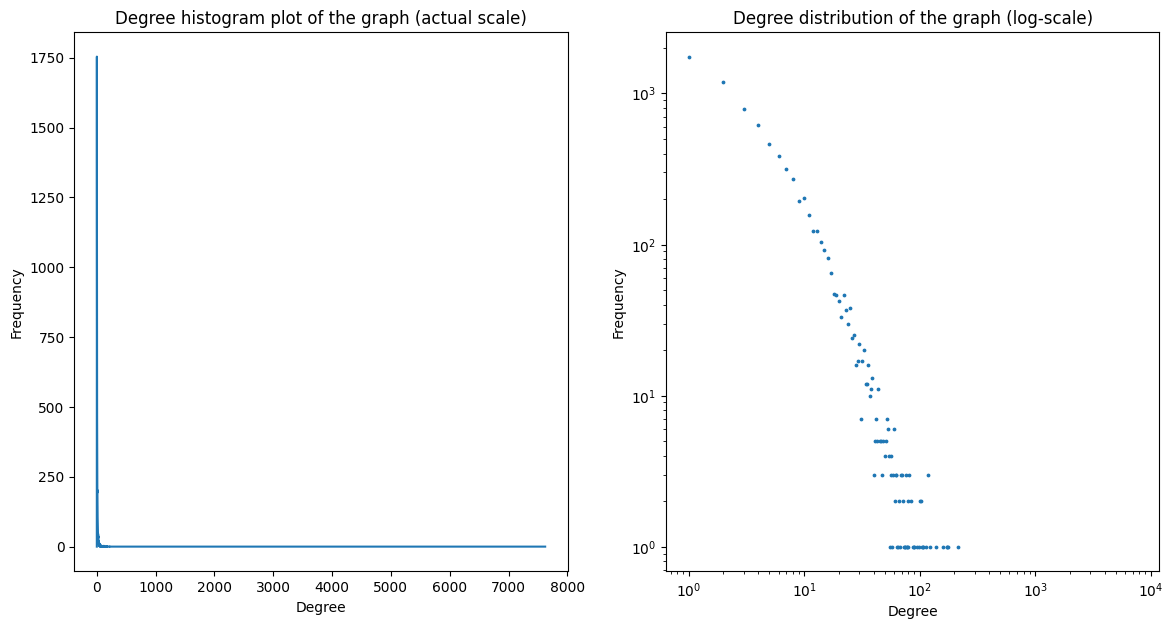

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

ax[0].plot(dh)
ax[0].set_title("Degree histogram plot of the graph (actual scale)")
ax[0].set_xlabel("Degree")
ax[0].set_ylabel("Frequency")

ax[1].scatter(np.arange(0, G.number_of_nodes()), dh, s=3)
ax[1].set_title("Degree distribution of the graph (log-scale)")
ax[1].set_xlabel("Degree")
ax[1].set_ylabel("Frequency")
ax[1].set_yscale('log')
ax[1].set_xscale('log')

It is evident that there exists some big hubs in the graph which are connected to many nodes, and there are many nodes who are connected to very few nodes. It depicts a power-law distribution as is noticed in most real-world graph data.

In [9]:
# Default pagerank without personalization
pr = nx.pagerank(G)

# Top 10 pagerank nodes
sorted(pr.items(), key=lambda item: item[1], reverse=True)[:10]

[(4811, 0.0034207101040038806),
 (4785, 0.003261332771883333),
 (3530, 0.0027190464788557044),
 (7237, 0.0025805027648334988),
 (3450, 0.002431449702413466),
 (2854, 0.0023561637916072954),
 (2510, 0.0023172590563457153),
 (524, 0.001966829068839528),
 (5127, 0.0018858456199523778),
 (6101, 0.0017762813264083851)]

In [10]:
# Top 10 nodes in terms of highest degree
sorted(G.degree(), key=lambda item: item[1], reverse=True)[:10]

[(7237, 216),
 (3530, 175),
 (4785, 174),
 (524, 172),
 (3450, 159),
 (2510, 140),
 (3597, 124),
 (2854, 119),
 (6101, 119),
 (5127, 119)]

As expected, most of the top 10 pagerank nodes also have high degree, as we analyzed it on this undirected graph.  

Interestingly, user `4811` has highest importance in terms of pagerank but is not in the top 10 users based on connections.

In [11]:
# Top 10 nodes in terms of degree centrality
(sorted(nx.centrality.degree_centrality(G).items(), key=lambda item: item[1], reverse=True))[:10]

[(7237, 0.02833530106257379),
 (3530, 0.022956841138659322),
 (4785, 0.022825659189295553),
 (524, 0.022563295290568018),
 (3450, 0.02085792994883904),
 (2510, 0.018365472910927456),
 (3597, 0.016266561721107176),
 (2854, 0.015610651974288339),
 (6101, 0.015610651974288339),
 (5127, 0.015610651974288339)]

Degree centrality is exactly same as the degree of a node normalized by maximum possible degree of the graph. Clearly, user `7237` has the highest degree of 216 and it is mutual follower with 2.8% of all the users this data has. 

The hubs in the graph are not as huge.

In [12]:
# Top 10 nodes in terms of eigenvector centrality
eigenvector_centrality = nx.centrality.eigenvector_centrality(G)
(sorted(eigenvector_centrality.items(), key=lambda item: item[1], reverse=True))[:10]

[(7237, 0.256134231102378),
 (3240, 0.19657824079541278),
 (3597, 0.19082938528653803),
 (763, 0.1816846597549269),
 (378, 0.16424646725239936),
 (2083, 0.16272123075395906),
 (1334, 0.1625309135128099),
 (3544, 0.151873662868128),
 (4809, 0.15128243225786764),
 (2734, 0.1464879585121097)]

In [13]:
# Top 10 nodes in terms of betweenness centrality - takes long time to compute ~7-8 minutes
betweenness_centrality = nx.centrality.betweenness_centrality(G)
(sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True))[:10]

[(7199, 0.08993132921587156),
 (7237, 0.08558851292049027),
 (2854, 0.077563011903684),
 (4356, 0.06724977863524628),
 (6101, 0.051804797126635244),
 (5454, 0.043613830289128734),
 (4338, 0.04289874773767917),
 (5127, 0.038412349470904675),
 (3450, 0.036932802520032906),
 (4785, 0.034960797890157956)]

User `7237` has the highest degree as well as highest eigenvector centrality (measuring how connected a node is to other important nodes in the network). This node is also a spotlight node and can surely be considered the most important node in this network in terms of overall influence to the whole network. In fact, this node also has one of the highest betweenness centralities, making the user very popular and influential to other nodes.

User `3597` also has very high eigenvector centrality and it has high number of followers (degree). 

User `3240`, `763` must have some very popular followers as they themselves do not have that many direct followers, but they have high eigenvector centrality. 

User `7199` has the highest betweenness centrality (percentage of all the shortest paths of any two nodes which pass through given node), but it is not in the top-10 list of degree centrality neither in eigenvector centrality; implying this user is itself not followed by many users, neither its followers have large number of followers, but acts as a bridge to many users who are not mutual follower. Basically, this user is efficiently connecting separate communities in the user base.

### Graph visuals using NetworkX

In [14]:
## Another way of plotting degree histogram directly using NX functions
## Usual histogram plot
# fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# n, bins, patches = ax[0].hist([deg for (node, deg) in G.degree()], bins=range(0, G.number_of_nodes()))  # output is two arrays
## Scatter plot
## Now we find the center of each bin from the bin edges
# bins_mean = [0.5 * (bins[i] + bins[i+1]) for i in range(len(n))]
# ax[1].scatter(bins_mean, n)
# ax[1].set_xscale('log')
# ax[1].set_yscale('log')

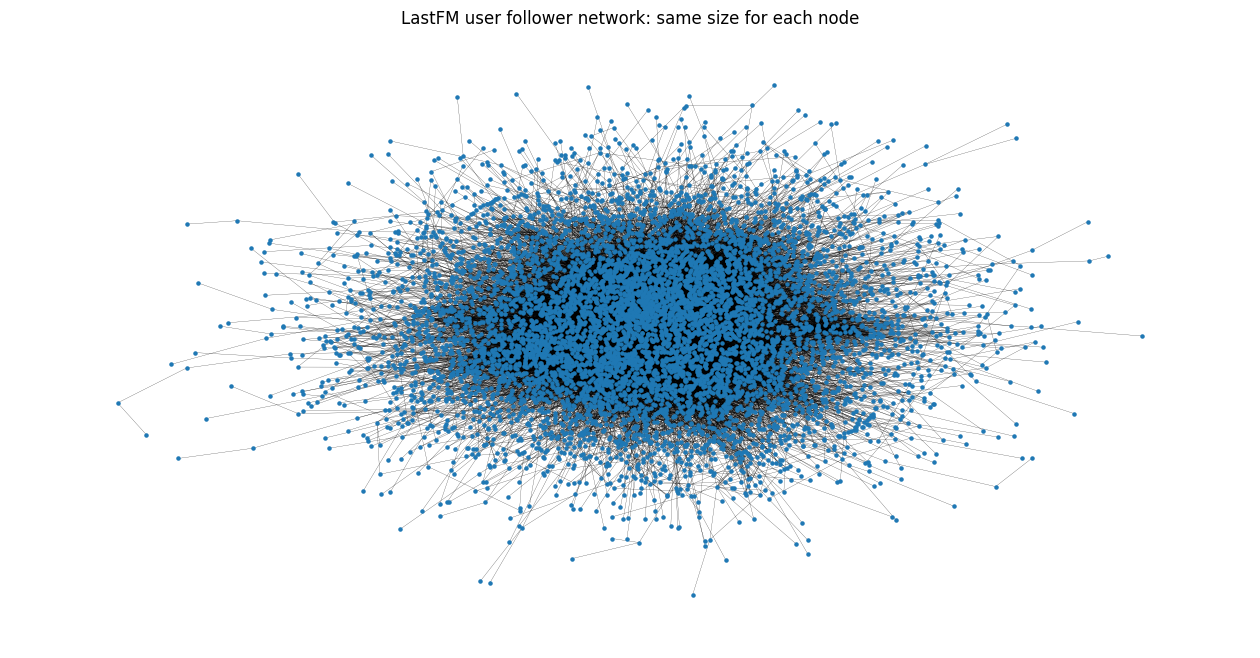

In [15]:
plot_options = {"node_size": 5, "with_labels": False, "width": 0.15}
pos = nx.spring_layout(G, k=2/np.sqrt(G.number_of_nodes()), iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(16, 8))
ax.set_title("LastFM user follower network: same size for each node")
ax.axis("off")
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

Based on above picture, there is no evident pattern on nodes forming clusters, which may not be completely correct as it is not easy to visualize a network with these many nodes & edges. 

(-1.203001646399498,
 1.1363506597280502,
 -1.1063507869839668,
 1.0003307536244392)

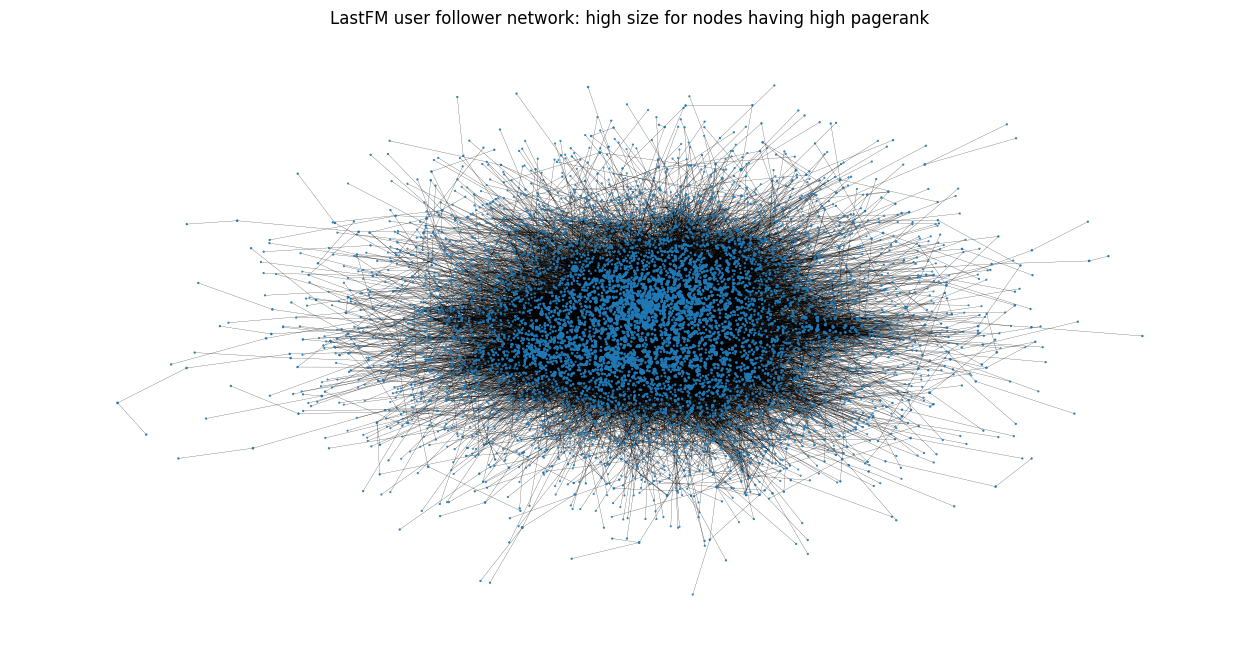

In [16]:
# Custom sized nodes - high for having high pagerank
node_size = [
    v * 6000 for v in pr.values()
]
plt.figure(figsize=(16, 8))
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.title("LastFM user follower network: high size for nodes having high pagerank")
plt.axis("off")

There are few nodes having high pagerank (which resembles the degree of that node in this case)

(-1.203001646399498,
 1.1363506597280502,
 -1.1063507869839668,
 1.0003307536244392)

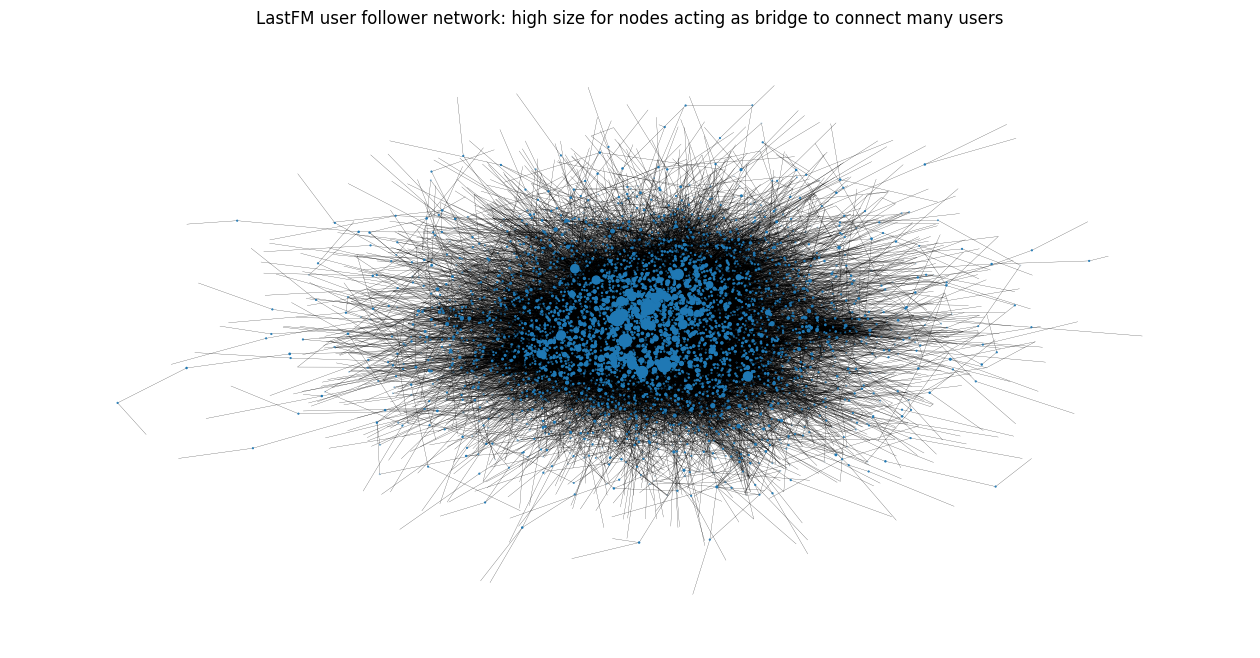

In [17]:
# Custom sized nodes - high for having high betweenness centrality
node_size = [
    v * 1200 for v in betweenness_centrality.values()
]
plt.figure(figsize=(16, 8))
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.title("LastFM user follower network: high size for nodes acting as bridge to connect many users")
plt.axis("off")

A handful of nodes have comparatively high betweenness centrality - they are forming bridge to connect different communities. This chart may help in understanding some cluster of users.

(-1.203001646399498,
 1.1363506597280502,
 -1.1063507869839668,
 1.0003307536244392)

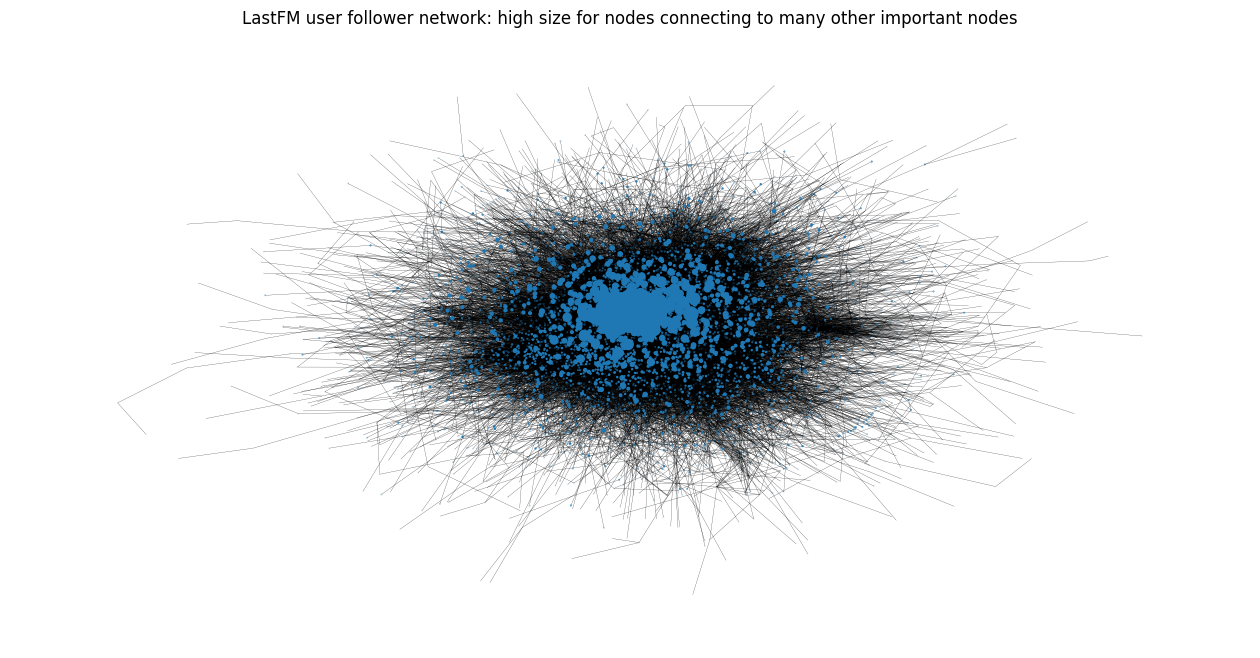

In [18]:
# Custom sized nodes - high for having high eigenvector centrality
node_size = [
    v * 1000 for v in eigenvector_centrality.values()
]
plt.figure(figsize=(16, 8))
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.title("LastFM user follower network: high size for nodes connecting to many other important nodes")
plt.axis("off")

There are decent number of users who follow other popular users; they themselves do not necessarily have high number of mutual followers.

## **Link Prediction**

## Create training data

* We will remove some edges randomly to create training data and test data. So that we can check the performance of the algorithm. 
* We will also create negative samples randomly, up to the size of positive samples in the original graph – the edges which does not exist are negative edges. This will be used in the classification algorithm.
* Essentially we will have some positive and some negative in both training & test datasets.

### Generate negative samples

Negative samples are to be generated from the original graph.

One more approach is to derive some hard negative samples - which can be done using, say, personalized pagerank scores. Choose those ones which are quite low in terms of rank. This may improve the node embedding learning.

In [26]:
def sample_negative_edges(G, num_neg_samples):
  # Implement the function that returns a list of negative edges.
  # The number of sampled negative edges is num_neg_samples. Not
  # considering the corner case when the number of possible negative edges
  # is less than num_neg_samples. In this implementation, self loops are 
  # not be considered as either a positive or negative edge. Also, notice that 
  # the LastFM network is an undirected graph, if (0, 1) is a positive 
  # edge, (1, 0) is also positive one.

  # Initialize empty list of negative edges
  neg_edge_list = []
  # initialize counter of neg samples
  counter = 0
  # initialize loop counter
  loop_counter = 0
  # maximum times to loop over
  max_loop = 3 * num_neg_samples

  # progress bar for maximum loop time
  pbar = tqdm(total = max_loop)

  nodes = list(G.nodes())

  # loop unitil sampled required negative edges
  # stop loop if loop counter is very high (compared to num_neg_samples)
  while (counter < num_neg_samples) and (loop_counter < max_loop):
    pbar.update(1)
    loop_counter += 1
    # sample two random nodes
    u, v = random.choices(nodes, k=2)
    # check for self loop and existence in the input undirected graph
    if ((u, v) not in G.edges()) & ((v, u) not in G.edges()) & (u != v):
      neg_edge_list.append((u, v))
      counter += 1
  # close progress bar
  pbar.close()
  return neg_edge_list


In [27]:
# Sample negative edges as many as the number of positive edges
neg_edge_list = sample_negative_edges(G, G.number_of_edges())

print(f"{len(neg_edge_list)} negative edges sampled from the graph having {G.number_of_edges()} positive edges")


  0%|          | 0/83418 [00:00<?, ?it/s]

27806 negative edges sampled from the graph having 27806 positive edges


In [28]:
# Sanity check for the negative sampling exercise

# Check any negative edges exist in input graph
assert not(any([e in G.edges() for e in neg_edge_list]))

### Remove few edges at random

To remove some positive edges from the graph while maintaining the connectedness of the graph!

Also sample same number of edges from the negative sample generated earlier, which will be included in the test set. Idea is to have $x$ number of positive and $x$ number of negative edges in training data; and also $y$ number of positive edges and $y$ number of negative edges in the test data.

In [29]:
# Number of edges to remove randomly - 10%
num_edges_to_remove = int(G.number_of_edges() * 0.1)
print(f"To remove {num_edges_to_remove} positive edges")

To remove 2780 positive edges


In [30]:
# Create a new graph with the same nodes as G
G_original = deepcopy(G)
print(G_original.number_of_edges())

27806


In [31]:
# Set seed
seed = 10 # None
random.seed(seed)
np.random.seed(seed)
if seed is not None:
  torch.manual_seed(seed)

In [32]:
# Remove edges while maintaining the graph is still connected

def remove_sample_edges(G, max_loop, num_edges_to_remove):
  # Loop counter initialize
  loop_counter = 0
  # removed edges counter initialize
  remove_counter = 0
  # list of edges removed initialize
  edges_removed = []

  # progress bar for maximum loop time
  pbar = tqdm(total = max_loop)

  # stop the loop if loop counter exceeds or required number of edges are removed
  while (loop_counter < max_loop) and (remove_counter < num_edges_to_remove):
    pbar.update(1)
    # select a random edge from G
    to_remove = random.choice(list(G.edges()))
    # remove the edge from G
    G.remove_edge(*to_remove)
    # If connected then update removal counters
    if nx.is_connected(G):
      remove_counter += 1
      loop_counter += 1
      edges_removed.append(to_remove)
    else:
      # if not connected then add back
      loop_counter += 1
      G.add_edge(*to_remove)
  # close progress bar
  pbar.close()
  # return the graph, list of edges removed, loop counter
  return (G, edges_removed, loop_counter)


In [33]:
# Maximum number of times to loop over
max_loop = num_edges_to_remove * 3
# execute edge removal
G, edges_removed, loop_counter =  remove_sample_edges(
    deepcopy(G_original), max_loop, num_edges_to_remove
)

# check how many removed
print(f"{len(edges_removed)} edges removed out of {num_edges_to_remove} requested")
print(f"looped over {loop_counter} times")

# check graph #nodes and #edges: before vs after
print(f"Number of nodes in original graph: {G_original.number_of_nodes()}")
print(f"Number of nodes in removed graph: {G.number_of_nodes()}")
print(f"Number of edges in original graph: {G_original.number_of_edges()}")
print(f"Number of edges in removed graph: {G.number_of_edges()}")

  0%|          | 0/8340 [00:00<?, ?it/s]

2780 edges removed out of 2780 requested
looped over 3027 times
Number of nodes in original graph: 7624
Number of nodes in removed graph: 7624
Number of edges in original graph: 27806
Number of edges in removed graph: 25026


In [34]:
# Sanity check for the edge removal exercise

# Check all removed edges exist in original graph
assert all([e in G_original.edges() for e in edges_removed])
# Check any removed edges exist in removed graph
assert not(any([e in G.edges() for e in edges_removed]))

In [35]:
np.random.seed(seed)

# generate indices for test to subset negative edge list into train & test
neg_index_ts = np.random.choice(range(G_original.number_of_edges()),
                                size=len(edges_removed), replace=False)
# subset negative edge samples for test set
neg_edge_list_ts = [neg_edge_list[i] for i in neg_index_ts]
print(f"number of negative edges for test: {len(neg_edge_list_ts)}")
# subset negative edge samples for train set
neg_edge_list_tr = [neg_edge_list[i] for i in range(G_original.number_of_edges()) if i not in neg_index_ts]
print(f"number of negative edges for train: {len(neg_edge_list_tr)}")

number of negative edges for test: 2780
number of negative edges for train: 25026


## Link prediction using Node Embedding

We will use multiple node embedding approaches to do the link prediction task, where each nodes will be mapped to some d-dimensional vector space. The mapping will be done in such a way so that the "*similar*" nodes are placed "*nearby*".

1. In first approach, the similarity is to be defined directly using adjacency matrix. If there exists an edge between a pair of nodes then they are said to be similar, else not.

2. `DeepWalk` approach will be used to define "*similar*" nodes. Here a random walker starts walking from each node, and the nodes which appear more often along the path in the neighborhood are said to be similar to the source node.

3. `Node2Vec` approach will also be tested to define "*similarity*". This approach is sort of biased random walk where the walker explores the local neighbourhood of the source node with certain probability as well as explores the global graph with some probability. This combines BFS and DFS in some sense with a controlling parameter of those probabilities - we can define how to bias the walker. Whereas, `DeepWalk` is purely random.

### Approach 1 based [Graph Factorization](https://static.googleusercontent.com/media/research.google.com/en/pubs/archive/40839.pdf)

* Initialize an embedding in some d-dimension space using random sample from U(0,1) 

* Define target label as 1 for positive edges and 0 for negative edges 

* Apply sigmoid on dot-product of the node embeddings of nodes representing an edge in training data 

* Cross-entropy loss for binary classification 

* Gradient descent (SGD, Adam, etc.) to update embedding vector minimizing loss

* Measure accuracy on the node pairs whose edges were removed earlier (test data). Also check performance on training data

In [36]:
# utility function to create tensor for a given edge list
def edge_list_to_tensor(edge_list):
  # Transforms the edge_list to tensor. The input edge_list
  # is a list of tuples and the resulting tensor
  # should have the shape [2 x len(edge_list)].
  # edge_index = torch.reshape(torch.tensor(edge_list), (2, len(edge_list))) # INCORRECT
  edge_index = torch.transpose(torch.tensor(edge_list), 0, 1)

  return edge_index

In [37]:
# Extract positive edge list of the training (pruned) graph
pos_edge_list = list(G.edges())
# Convert pos & neg edge lists to pytorch tensor for training
pos_edge_index = edge_list_to_tensor(pos_edge_list)
neg_edge_index = edge_list_to_tensor(neg_edge_list_tr)
# edge index of removed edges for test data, both pos & neg
tst_edge_index_pos = edge_list_to_tensor(edges_removed)
tst_edge_index_neg = edge_list_to_tensor(neg_edge_list_ts)

In [38]:
print(f"The pos_edge_index tensor has shape {pos_edge_index.shape}")
print(f"The neg_edge_index tensor has shape {neg_edge_index.shape}")
print(f"The tst_edge_index_pos tensor has shape {tst_edge_index_pos.shape}")
print(f"The tst_edge_index_neg tensor has shape {tst_edge_index_neg.shape}")

The pos_edge_index tensor has shape torch.Size([2, 25026])
The neg_edge_index tensor has shape torch.Size([2, 25026])
The tst_edge_index_pos tensor has shape torch.Size([2, 2780])
The tst_edge_index_neg tensor has shape torch.Size([2, 2780])


In [39]:
# Sanity check on converting edges to tensor
# all positives must be in G
assert all([e in G.edges() for e in np.transpose(pos_edge_index.numpy())])
assert all([e in G_original.edges() for e in np.transpose(tst_edge_index_pos.numpy())])
# none of the negatives are expected to be in G
assert not(any([e in G.edges() for e in np.transpose(neg_edge_index.numpy())]))
assert not(any([e in G_original.edges() for e in np.transpose(tst_edge_index_neg.numpy())]))

* Define **64 dimensional** vector for each node in the pruned network - embedding dimension.
* Initalize the matrix under *uniform distribution*, in the range of $[0, 1)$

In [40]:
G.number_of_nodes()

7624

In [41]:
# utility function to initialize embedding for the nodes of specified dimension
def create_node_emb(num_node, embedding_dim=64):
  # create the node embedding matrix.
  # A torch.nn.Embedding layer will be returned. The weight matrix of returned 
  # layer should be initialized under uniform distribution. 

  # default embedding is initialized from Normal(0,1)
  emb = nn.Embedding(num_node, embedding_dim)
  # change embedding weight to be initialized from U(0,1)
  emb.weight.data = torch.rand(num_node, embedding_dim)

  return emb

emb_1 = create_node_emb(G.number_of_nodes())
ids = torch.LongTensor([0, 3])

# Print the embedding layer
print("Embedding: {}".format(emb_1))

# An example that gets the embeddings for node 0 and 3
print(emb_1(ids))

Embedding: Embedding(7624, 64)
tensor([[0.4704, 0.1459, 0.8301, 0.2476, 0.5478, 0.3578, 0.2881, 0.1115, 0.0438,
         0.5152, 0.5720, 0.9831, 0.4711, 0.2192, 0.7904, 0.1420, 0.4822, 0.0035,
         0.3854, 0.7274, 0.6631, 0.0106, 0.4086, 0.9128, 0.7020, 0.1535, 0.9124,
         0.0389, 0.3683, 0.3740, 0.0477, 0.5152, 0.5776, 0.5328, 0.3022, 0.6805,
         0.7007, 0.3443, 0.4711, 0.0265, 0.5674, 0.3408, 0.4370, 0.8199, 0.1725,
         0.8431, 0.3098, 0.1127, 0.8799, 0.6637, 0.8848, 0.5932, 0.9162, 0.8007,
         0.8868, 0.1663, 0.4170, 0.6794, 0.2383, 0.7575, 0.7657, 0.7333, 0.7003,
         0.2664],
        [0.6729, 0.6627, 0.6918, 0.5037, 0.0361, 0.3815, 0.4772, 0.4678, 0.4835,
         0.2193, 0.6120, 0.6370, 0.7471, 0.3913, 0.8879, 0.7383, 0.6754, 0.1216,
         0.7975, 0.9880, 0.0492, 0.9526, 0.2396, 0.7572, 0.2400, 0.2572, 0.9044,
         0.2019, 0.3475, 0.6823, 0.8416, 0.0149, 0.6036, 0.9921, 0.5773, 0.1571,
         0.3340, 0.5609, 0.3254, 0.2820, 0.7609, 0.6727, 0.5

#### Visualize embedding before training

Let's try to visualize the randomly initialized embedding. We will visualize it again once we learn the weights after training.

Project the node embeddings on 2-D space and plot it; use the node labels (the country id a user belongs to) as color.

(7624, 2)


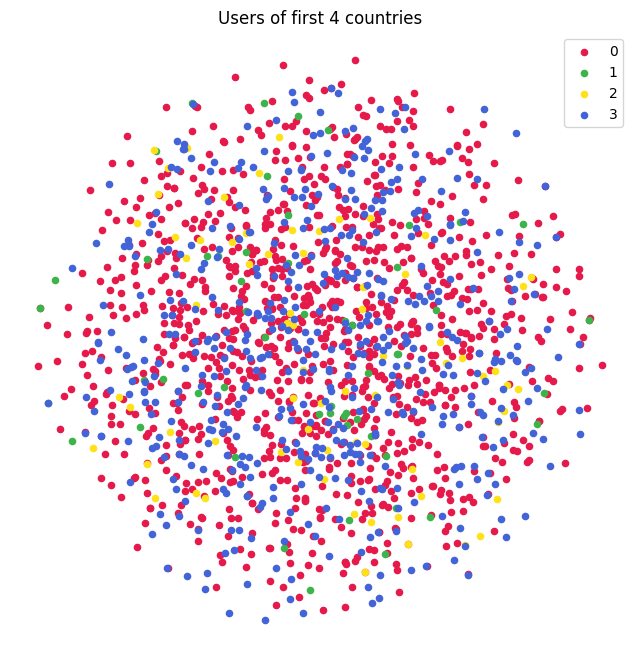

In [42]:
@torch.no_grad()
def visualize_emb(emb_np, G, labels, col_list, ncountries=4, dim=2):
  """
  emb: node embedding weights as numpy array
  G: nx graph
  labels: dict of users as keys and country id as values
  col_list: list of colors for each distinct country ids
  ncountries: number of countries' users to visualize (first xx countries)
  dim: compress into these many dimensions, either 2 or 3
  """
  # compress embedding weights to lower dim using TSNE
  components = TSNE(n_components=dim).fit_transform(emb_np)
  print(components.shape)
  # list of country ids
  country_list = list(set(labels.values()))
  plt.figure(figsize=(8, 8))
  # loop over each country id
  for i in range(ncountries):
    # list of users belonging to country i
    user_country_i = [
        user_country[0] for user_country in labels.items() if user_country[1] == country_list[i]
    ]
    # plot all users of country i with a given color for country i
    if dim==2:
      plt.scatter(components[user_country_i, 0], components[user_country_i, 1],
                  s=20, color=col_list[i], label=country_list[i])
    elif dim==3:
      plt.axes(projection='3d')
      plt.scatter(components[user_country_i, 0], components[user_country_i, 1],
                  components[user_country_i, 2],
                  s=20, color=col_list[i], label=country_list[i])
    else:
      raise Exception("dim must be 2 or 3")

  plt.legend()
  plt.title(f"Users of first {ncountries} countries")
  plt.axis('off')
  plt.show()

# list of color hex codes for each country
col_list = [
    '#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4',
    '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff',
    '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1'
]
# Visualize the initial random embeddding
visualize_emb(emb_1.weight.data.numpy(), G, labels, col_list)

As expected, all the colored dots are scattered everywhere randomly, there is no obvious pattern.

#### Training function

**Optimize embeddings** for the task of classifying edges as positive or negative. Given an edge and the embeddings for each node, the dot product of the embeddings, followed by a sigmoid, should give us the likelihood of that edge being either positive (output of sigmoid > 0.5) or negative (output of sigmoid < 0.5)

In [43]:
from torch.optim import SGD, Adam

def accuracy(pred, label):
  # The accuracy function. This function takes the 
  # pred tensor (the resulting tensor after sigmoid) and the label 
  # tensor (torch.LongTensor). Predicted value greater than 0.5 will 
  # be classified as label 1. Else it will be classified as label 0.

  accu = (
      torch.sum((pred >= 0.5) & (label == 1)).numpy()
      + torch.sum((pred < 0.5) & (label == 0)).numpy()
  ) / len(label)

  return accu

# utility function to get dot product of embedding weights of nodes of an edge
def dotprod_edge_emb(emb, edge_indices):
  """
  emb: embedding weights of all the nodes
  edge_indices: edge indices of (u,v). The respective indices which is used
      in the dot product
  returns the dot product of the input edges - size 1-D with number of edges
  """
  selected_emb = emb(edge_indices) # [0]: u, [1]: v
  # matrix multiply to get dot product
  # u: (25026*2 X 16), v: (25026*2 X 16)
  # u * v.T ==> 25026*2 X 25026*2
  # we want only the diagonals as they correspond to respective edge pairs
  # u * v.T [1,1] = u1 dot v1; u * v.T [2,2] = u2 dot v2
  # dot_prod = torch.diagonal(torch.matmul(train_emb[0], train_emb[1].T))
  # One more approach is: elementwise multiply u & v, and then rowsum
  dot_prod = torch.sum(selected_emb[0] * selected_emb[1], dim=1)
  return dot_prod



def train(emb, loss_fn, sigmoid, train_label, train_edge,
          epochs = 500, learning_rate = 0.5):
  """
  emb: input embedding vectors of the nodes
  loss_fn: loss function to use to update embedding weights
  sigmoid: pytorch sigmoid function
  train_label: pytorch tensor of positive and negative labels of input edges
  train_edge: indices of positive and negative edges in training
  epochs: number of epochs (number of forward passes through the whole input)
  learning_rate: the learning rate to use while updating weights using gradients

  Does not return anything explicitly. The input embedding weights are updated.
  """
  # Train the embedding layer here. 
  # (1) Get the embeddings of the nodes in train_edge
  # (2) Dot product the embeddings between each node pair
  # (3) Feed the dot product result into sigmoid
  # (4) Feed the sigmoid output into the loss_fn
  # (5) Print both loss and accuracy of each epoch 
  # (6) Update the embeddings using the loss and optimizer 
  # (as a sanity check, the loss should decrease during training)

  # optimizer = SGD(emb.parameters(), lr=learning_rate, momentum=0.9)
  optimizer = Adam(emb.parameters(), lr=learning_rate)

  for i in tqdm(range(1, epochs+1)):
    # get dot prod of train edges
    dot_prod = dotprod_edge_emb(emb, train_edge)
    # sigmoid of dot product
    pred = sigmoid(dot_prod)
    # calculate accuracy using true label
    accu = accuracy(pred, train_label)
    # Clear gradients
    optimizer.zero_grad()
    # get the loss
    loss = loss_fn(pred, train_label)
    # Derive gradients
    loss.backward()
    # Update parameters based on gradients
    optimizer.step()
    # show progress
    if i % 10 == 0:
      print(f"epoch {i:03d}: loss {loss:.6f} accuracy {accu:.6f}")


Define inputs for training the embedding

In [44]:
# define loss function
loss_fn = nn.BCELoss()
# define sigmoid function
sigmoid = nn.Sigmoid()

print(pos_edge_index.shape)

# Generate the positive and negative labels
pos_label = torch.ones(pos_edge_index.shape[1], )
neg_label = torch.zeros(neg_edge_index.shape[1], )

# Concat positive and negative labels into one tensor
train_label = torch.cat([pos_label, neg_label], dim=0)
print(train_label.shape)

# Concat positive and negative edges into one tensor
# We could have split the edges into validation/test sets
train_edge = torch.cat([pos_edge_index, neg_edge_index], dim=1)
print(train_edge.shape)

test_edge = torch.cat([tst_edge_index_pos, tst_edge_index_neg], dim=1)
print(test_edge.shape)
test_label = np.concatenate((np.ones(tst_edge_index_pos.shape[1]), np.zeros(tst_edge_index_neg.shape[1])))
print(test_label.shape)

if seed is not None:
  torch.manual_seed(seed)

# initialize embedding weights of nodes
emb_1 = create_node_emb(G.number_of_nodes())


torch.Size([2, 25026])
torch.Size([50052])
torch.Size([2, 50052])
torch.Size([2, 5560])
(5560,)


Check the initial embedding weights based predictions **before** training

In [45]:
# Check the initial embedding based predictions before training
with torch.no_grad():
  print(f"#of neg edges predicted as neg BEFORE training: {sum(sigmoid(dotprod_edge_emb(emb_1, neg_edge_index)) < 0.5)}, out of {neg_edge_index.shape[1]}, accuracy {sum(sigmoid(dotprod_edge_emb(emb_1, neg_edge_index)) < 0.5)/neg_edge_index.shape[1]:.2%}")
  print(f"#of pos edges predicted as pos BEFORE training: {sum(sigmoid(dotprod_edge_emb(emb_1, pos_edge_index)) >= 0.5)}, out of {pos_edge_index.shape[1]}, accuracy {sum(sigmoid(dotprod_edge_emb(emb_1, pos_edge_index)) >= 0.5)/pos_edge_index.shape[1]:.2%}")
  print(f"#of all edges predicted as correctly BEFORE training: {sum(sigmoid(dotprod_edge_emb(emb_1, neg_edge_index)) < 0.5) + sum(sigmoid(dotprod_edge_emb(emb_1, pos_edge_index)) >= 0.5)}, out of {train_edge.shape[1]}, accuracy {(sum(sigmoid(dotprod_edge_emb(emb_1, pos_edge_index)) >= 0.5) + sum(sigmoid(dotprod_edge_emb(emb_1, neg_edge_index)) < 0.5))/train_edge.shape[1]:.2%}")
  print(f"prob of first 5 neg edges of being pos BEFORE training: {sigmoid(dotprod_edge_emb(emb_1, neg_edge_index))[:5]}")
  print(f"prob of first 5 pos edges of being pos BEFORE training: {sigmoid(dotprod_edge_emb(emb_1, pos_edge_index))[:5]}")
  print("-----------------------------------------------------")
  print(f"#of pos test edges predicted as pos BEFORE training: {sum(sigmoid(dotprod_edge_emb(emb_1, tst_edge_index_pos)) >= 0.5)}, out of {tst_edge_index_pos.shape[1]}, accuracy {sum(sigmoid(dotprod_edge_emb(emb_1, tst_edge_index_pos)) >= 0.5)/tst_edge_index_pos.shape[1]:.2%}")
  print(f"#of neg test edges predicted as neg BEFORE training: {sum(sigmoid(dotprod_edge_emb(emb_1, tst_edge_index_neg)) < 0.5)}, out of {tst_edge_index_neg.shape[1]}, accuracy {sum(sigmoid(dotprod_edge_emb(emb_1, tst_edge_index_neg)) < 0.5)/tst_edge_index_neg.shape[1]:.2%}")
  print(f"#of all test edges predicted as correctly BEFORE training: {sum(sigmoid(dotprod_edge_emb(emb_1, tst_edge_index_neg)) < 0.5) + sum(sigmoid(dotprod_edge_emb(emb_1, tst_edge_index_pos)) >= 0.5)}, out of {tst_edge_index_neg.shape[1]+tst_edge_index_pos.shape[1]}, accuracy {(sum(sigmoid(dotprod_edge_emb(emb_1, tst_edge_index_pos)) >= 0.5) + sum(sigmoid(dotprod_edge_emb(emb_1, tst_edge_index_neg)) < 0.5))/(tst_edge_index_neg.shape[1]+tst_edge_index_pos.shape[1]):.2%}")


#of neg edges predicted as neg BEFORE training: 0, out of 25026, accuracy 0.00%
#of pos edges predicted as pos BEFORE training: 25026, out of 25026, accuracy 100.00%
#of all edges predicted as correctly BEFORE training: 25026, out of 50052, accuracy 50.00%
prob of first 5 neg edges of being pos BEFORE training: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
prob of first 5 pos edges of being pos BEFORE training: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
-----------------------------------------------------
#of pos test edges predicted as pos BEFORE training: 2780, out of 2780, accuracy 100.00%
#of neg test edges predicted as neg BEFORE training: 0, out of 2780, accuracy 0.00%
#of all test edges predicted as correctly BEFORE training: 2780, out of 5560, accuracy 50.00%


In [46]:
# Precision, recall, f1-score on training input before training
with torch.no_grad():
  print(precision_recall_fscore_support(
    train_label.numpy(),
    (sigmoid(dotprod_edge_emb(emb_1, train_edge)) >= 0.5).numpy() * 1,
    average = 'binary'
  ))

(0.5, 1.0, 0.6666666666666666, None)


As noted above, **precision is 50% and recall is 100%** for the positive edges in **training data** based on prediction using dot-product of node embeddings **before training**

#### Train
**Train** the node embedding weights using our **approach #1**

In [47]:
# Train the embedding using first approach!
train(emb_1, loss_fn, sigmoid, train_label, train_edge, epochs = 150, learning_rate = 0.005)

  0%|          | 0/150 [00:00<?, ?it/s]

epoch 010: loss 8.006284 accuracy 0.500000
epoch 020: loss 5.294839 accuracy 0.500000
epoch 030: loss 4.049035 accuracy 0.500000
epoch 040: loss 3.056053 accuracy 0.500000
epoch 050: loss 2.262970 accuracy 0.500000
epoch 060: loss 1.657838 accuracy 0.500000
epoch 070: loss 1.222728 accuracy 0.501219
epoch 080: loss 0.925599 accuracy 0.511228
epoch 090: loss 0.725940 accuracy 0.547571
epoch 100: loss 0.588392 accuracy 0.621534
epoch 110: loss 0.488955 accuracy 0.715296
epoch 120: loss 0.413392 accuracy 0.804383
epoch 130: loss 0.353615 accuracy 0.876608
epoch 140: loss 0.304950 accuracy 0.925997
epoch 150: loss 0.264555 accuracy 0.957424


#### Evaluate performance

Check the embedding weights based predictions **after** training

In [48]:
# Check the initial embedding based predictions after training
with torch.no_grad():
  print(f"#of neg edges predicted as neg AFTER training: {sum(sigmoid(dotprod_edge_emb(emb_1, neg_edge_index)) < 0.5)}, out of {neg_edge_index.shape[1]}, accuracy {sum(sigmoid(dotprod_edge_emb(emb_1, neg_edge_index)) < 0.5)/neg_edge_index.shape[1]:.2%}")
  print(f"#of pos edges predicted as pos AFTER training: {sum(sigmoid(dotprod_edge_emb(emb_1, pos_edge_index)) >= 0.5)}, out of {pos_edge_index.shape[1]}, accuracy {sum(sigmoid(dotprod_edge_emb(emb_1, pos_edge_index)) >= 0.5)/pos_edge_index.shape[1]:.2%}")
  print(f"#of all edges predicted as correctly AFTER training: {sum(sigmoid(dotprod_edge_emb(emb_1, neg_edge_index)) < 0.5) + sum(sigmoid(dotprod_edge_emb(emb_1, pos_edge_index)) >= 0.5)}, out of {train_edge.shape[1]}, accuracy {(sum(sigmoid(dotprod_edge_emb(emb_1, pos_edge_index)) >= 0.5) + sum(sigmoid(dotprod_edge_emb(emb_1, neg_edge_index)) < 0.5))/train_edge.shape[1]:.2%}")
  print(f"prob of first 5 neg edges of being pos AFTER training: {sigmoid(dotprod_edge_emb(emb_1, neg_edge_index))[:5]}")
  print(f"prob of first 5 pos edges of being pos AFTER training: {sigmoid(dotprod_edge_emb(emb_1, pos_edge_index))[:5]}")
  print("-----------------------------------------------------")
  print(f"#of pos test edges predicted as pos AFTER training: {sum(sigmoid(dotprod_edge_emb(emb_1, tst_edge_index_pos)) >= 0.5)}, out of {tst_edge_index_pos.shape[1]}, accuracy {sum(sigmoid(dotprod_edge_emb(emb_1, tst_edge_index_pos)) >= 0.5)/tst_edge_index_pos.shape[1]:.2%}")
  print(f"#of neg test edges predicted as neg AFTER training: {sum(sigmoid(dotprod_edge_emb(emb_1, tst_edge_index_neg)) < 0.5)}, out of {tst_edge_index_neg.shape[1]}, accuracy {sum(sigmoid(dotprod_edge_emb(emb_1, tst_edge_index_neg)) < 0.5)/tst_edge_index_neg.shape[1]:.2%}")
  print(f"#of all test edges predicted as correctly AFTER training: {sum(sigmoid(dotprod_edge_emb(emb_1, tst_edge_index_neg)) < 0.5) + sum(sigmoid(dotprod_edge_emb(emb_1, tst_edge_index_pos)) >= 0.5)}, out of {tst_edge_index_neg.shape[1]+tst_edge_index_pos.shape[1]}, accuracy {(sum(sigmoid(dotprod_edge_emb(emb_1, tst_edge_index_pos)) >= 0.5) + sum(sigmoid(dotprod_edge_emb(emb_1, tst_edge_index_neg)) < 0.5))/(tst_edge_index_neg.shape[1]+tst_edge_index_pos.shape[1]):.2%}")


#of neg edges predicted as neg AFTER training: 23113, out of 25026, accuracy 92.36%
#of pos edges predicted as pos AFTER training: 24936, out of 25026, accuracy 99.64%
#of all edges predicted as correctly AFTER training: 48049, out of 50052, accuracy 96.00%
prob of first 5 neg edges of being pos AFTER training: tensor([0.1801, 0.3733, 0.3025, 0.3502, 0.4501])
prob of first 5 pos edges of being pos AFTER training: tensor([0.7709, 0.9538, 0.8231, 0.8405, 0.8292])
-----------------------------------------------------
#of pos test edges predicted as pos AFTER training: 2570, out of 2780, accuracy 92.45%
#of neg test edges predicted as neg AFTER training: 478, out of 2780, accuracy 17.19%
#of all test edges predicted as correctly AFTER training: 3048, out of 5560, accuracy 54.82%


In [49]:
# Precision, recall, f1-score on training input after training
with torch.no_grad():
  print(precision_recall_fscore_support(
    train_label.numpy(),
    (sigmoid(dotprod_edge_emb(emb_1, train_edge)) >= 0.5).numpy() * 1,
    average = 'binary'
  ))

(0.9287496741033185, 0.9964037401102853, 0.961387951807229, None)


In [50]:
# Precision, recall, f1-score on test input after training
with torch.no_grad():
  print(precision_recall_fscore_support(
    test_label,
    (sigmoid(dotprod_edge_emb(emb_1, test_edge)) >= 0.5).numpy() * 1,
    average = 'binary'
  ))

(0.527504105090312, 0.9244604316546763, 0.6717198118139049, None)


**After training**, *f1-score* became **96% on training data** - *sign of overfitting!*. And only **67% on test set**.

We could also have used *cross-validation to tune the epochs and learning rate* hyperparameter

**Performance of approach 1**

As noted above, approach 1 of node embedding weights learnt from adjacency matrix was able to correctly predict 3,032 out of 5,560 edges in test set, **55% accuracy**.


#### Visualize embedding after training


(7624, 2)


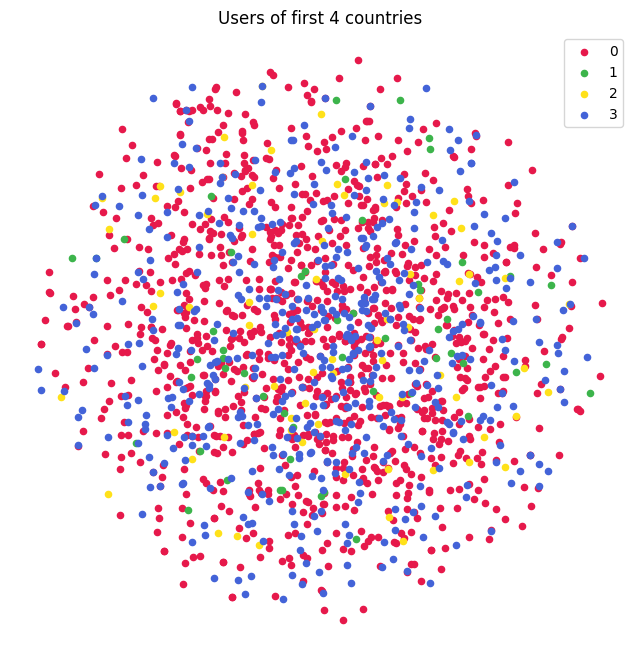

In [51]:
# Visualize the trained embeddding with approach 1
with torch.no_grad():
  visualize_emb(emb_1.weight.data.numpy(), G, labels, col_list)

As noted from the visual, this approach could not locate the users by their country very well. We may say the blue colored dots are leaning on the left, but not much beyond that.

### Approach 2 based on [DeepWalk](https://arxiv.org/pdf/1403.6652.pdf)

First, installing Pytorch Geometric. It is a bit tricky and may take time :(

In [52]:
# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 77.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 67.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 37.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-eekbz6n9
  Running command git clone --filter=blob:none --quiet https://github.com/py

In [53]:
# use GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [54]:
from torch_geometric.nn import Node2Vec

**Define** `Node2Vec` **model** object using parameters relevant for `DeepWalk` (`p=1`, `q=1`).

Also define the data loader with batch size and the optimizer.

In [55]:
if seed is not None:
  torch.manual_seed(seed)

# p=1 & q=1 implies DeepWalk. These are the bias parameters to control BFS-DFS combo
# use the positive edges of the pruned graph
model_dw = Node2Vec(pos_edge_index, embedding_dim=64, 
                 walk_length=6,                        # lenght of rw
                 context_size=4, walks_per_node=20,
                 num_negative_samples=1, 
                 p=1, q=1,                             # bias parameters
                 sparse=True).to(device)

# Data loader
loader_dw = model_dw.loader(batch_size=108, shuffle=True, num_workers=2)
# Optimizer
optimizer_dw = torch.optim.SparseAdam(list(model_dw.parameters()), lr=0.01)

#### Peek random walks

In [56]:
for idx, (pos_rw, neg_rw) in enumerate(loader_dw):
    print(idx, pos_rw.shape, neg_rw.shape)

0 torch.Size([6480, 4]) torch.Size([6480, 4])
1 torch.Size([6480, 4]) torch.Size([6480, 4])
2 torch.Size([6480, 4]) torch.Size([6480, 4])
3 torch.Size([6480, 4]) torch.Size([6480, 4])
4 torch.Size([6480, 4]) torch.Size([6480, 4])
5 torch.Size([6480, 4]) torch.Size([6480, 4])
6 torch.Size([6480, 4]) torch.Size([6480, 4])
7 torch.Size([6480, 4]) torch.Size([6480, 4])
8 torch.Size([6480, 4]) torch.Size([6480, 4])
9 torch.Size([6480, 4]) torch.Size([6480, 4])
10 torch.Size([6480, 4]) torch.Size([6480, 4])
11 torch.Size([6480, 4]) torch.Size([6480, 4])
12 torch.Size([6480, 4]) torch.Size([6480, 4])
13 torch.Size([6480, 4]) torch.Size([6480, 4])
14 torch.Size([6480, 4]) torch.Size([6480, 4])
15 torch.Size([6480, 4]) torch.Size([6480, 4])
16 torch.Size([6480, 4]) torch.Size([6480, 4])
17 torch.Size([6480, 4]) torch.Size([6480, 4])
18 torch.Size([6480, 4]) torch.Size([6480, 4])
19 torch.Size([6480, 4]) torch.Size([6480, 4])
20 torch.Size([6480, 4]) torch.Size([6480, 4])
21 torch.Size([6480, 4]

In [57]:
idx, (pos_rw, neg_rw) = next(enumerate(loader_dw))

In [58]:
idx

0

In [59]:
(pos_rw.shape, neg_rw.shape)

(torch.Size([6480, 4]), torch.Size([6480, 4]))

In [60]:
pos_rw

tensor([[6008, 6008, 6008, 6008],
        [6693, 6693, 6693, 6693],
        [7107, 7107, 7107, 7107],
        ...,
        [6461, 6461, 6461, 6461],
        [1966, 1966, 1966, 1966],
        [2296, 2296, 2296, 2296]])

In [61]:
neg_rw

tensor([[6008,  488, 3552, 1320],
        [6693, 3416,  888, 7370],
        [7107, 2654, 6091, 6290],
        ...,
        [6258, 4463, 6772, 2986],
        [6114, 2640, 7434,  865],
        [5483, 1436, 7254, 5543]])

In [62]:
neg_rw[0][:2].numpy() in G.edges()

False

#### Training function

In [63]:
def train(model, loader, optimizer):
  model.train()
  total_loss = 0
  for pos_rw, neg_rw in loader:
      optimizer.zero_grad()
      loss = model.loss(pos_rw.to(device), neg_rw.to(device))
      loss.backward()
      optimizer.step()
      total_loss += loss.item()
  return total_loss / len(loader)

#### Test function

* Extract the node embedding weights for each nodes participating in an edge; do it for both positive and negative edges
* We already have the true label (positive edge: 1, negative edge: 0)
* Now we have multiple options to define the respective feature of the edge between nodes $u$ and $v$:
    * Concatenate embedding weights of both nodes
    * Sum or average of embedding weights of both nodes
    * Hadamard product of embedding weights of both nodes
    * Euclidean distance between the weights of both nodes 
* Will experiment with the above operators to see which fits better. As per the observation made by the authors of [Node2Vec paper](https://arxiv.org/pdf/1607.00653.pdf), "*Hadamard operator when used with node2vec is highly stable*"
* Use the edge feature as identified in above step and build a logistic regression model with L2 regularization to get the accuracy of predicting a link on training data


Idea is to use the same data as used in previous approach's training; the mix of positive and negative edges with the true labels. And calculate the accuracy of the prediction, which will be reported during each epoch of the embedding weights learning.

In [64]:
# utility function to get feature vector from embedding weights of nodes of an edge
def feature_edge_emb(emb, edge_indices):
  """
  emb: embedding weights of all the nodes
  edge_indices: edge indices of (u,v). The respective indices which is used
      in the feature creation
  returns the operator transformed feature of the input edges - size 1 X d-dimension for each edge
  """
  selected_emb = emb[edge_indices] # [0]: u, [1]: v
  # elementwise multiply to get Hadamard product
  # u: (25026*2 X 16), v: (25026*2 X 16)
  # elementwise multiply u & v:
  edge_feature = selected_emb[0] * selected_emb[1]
  # concat:
  # edge_feature = torch.cat([selected_emb[0], selected_emb[1]], dim = 1)
  # sum:
  # edge_feature = (selected_emb[0] + selected_emb[1])
  # euclidean distance:
  # edge_feature = (selected_emb[0] - selected_emb[1]).pow(2).sqrt()
  # print(edge_feature.shape)
  return edge_feature

# Don't update gradients
@torch.no_grad()
def test(model, train_label, train_edge, test_edge, test_label):
  # put the model in evaluation mode
  model.eval()
  # extract the node embeddings from the current state of the model
  z = model().data
  # get edge feature of training data
  feature = feature_edge_emb(z, train_edge)
  # fit logistic regression using training label and training feature
  clf = LogisticRegression().fit(feature.detach().cpu().numpy(),
                                 train_label.detach().cpu().numpy())
  # prediction of train edges
  train_pred = clf.predict(feature.detach().cpu().numpy())
  # calculate accuracy on training input
  acc_train = clf.score(feature.detach().cpu().numpy(),
                        train_label.detach().cpu().numpy())
  # calculate accuracy on test edges
  feature_test = feature_edge_emb(z, test_edge)
  # prediction of test edges
  test_pred = clf.predict(feature_test.detach().cpu().numpy())
  acc_test = clf.score(feature_test.detach().cpu().numpy(),
                        test_label)
  return acc_train, acc_test, train_pred, test_pred

#### Train
See the learning in action!

In [65]:
for epoch in tqdm(range(1, 151)):
  # get the loss after one epoch
  loss = train(model_dw, loader_dw, optimizer_dw)
  # get the accuracy of prediction
  acc_train, acc_test, train_pred, test_pred = test(
      model_dw, train_label, train_edge, test_edge, test_label
  )
  # show progress
  if epoch % 10 == 0:
    print(f"epoch {epoch:03d}: loss {loss:.6f} train acc {acc_train:.4f} test acc {acc_test:.4f}")

  0%|          | 0/150 [00:00<?, ?it/s]

epoch 010: loss 1.011605 train acc 0.7632 test acc 0.5883
epoch 020: loss 0.795622 train acc 0.9080 test acc 0.7581
epoch 030: loss 0.764745 train acc 0.9490 test acc 0.8232
epoch 040: loss 0.756547 train acc 0.9601 test acc 0.8459
epoch 050: loss 0.754188 train acc 0.9629 test acc 0.8522
epoch 060: loss 0.753185 train acc 0.9633 test acc 0.8540
epoch 070: loss 0.754238 train acc 0.9639 test acc 0.8603
epoch 080: loss 0.754624 train acc 0.9645 test acc 0.8572
epoch 090: loss 0.754224 train acc 0.9649 test acc 0.8561
epoch 100: loss 0.755112 train acc 0.9645 test acc 0.8567
epoch 110: loss 0.754570 train acc 0.9639 test acc 0.8586
epoch 120: loss 0.754902 train acc 0.9640 test acc 0.8590
epoch 130: loss 0.754742 train acc 0.9645 test acc 0.8601
epoch 140: loss 0.754880 train acc 0.9638 test acc 0.8581
epoch 150: loss 0.754068 train acc 0.9631 test acc 0.8595


#### Evaluate performance

In [66]:
# Precision, recall, f1-score on training input after training
precision_recall_fscore_support(
    train_label.numpy(),
    train_pred,
    average = 'binary'
)

(0.9695324527996111, 0.9562055462319188, 0.962822885652209, None)

In [67]:
# Precision, recall, f1-score on test input after training
precision_recall_fscore_support(
    test_label,
    test_pred,
    average = 'binary'
)

(0.9586966498393759, 0.7514388489208633, 0.8425085702762655, None)

In [68]:
# Train accuracy
print(f"Predicted {sum(train_pred == np.array(train_label))} edges correctly out of {train_pred.shape[0]} edges in train. Accuracy: {sum(train_pred == np.array(train_label))/train_pred.shape[0]:.2%}")
# Test accuracy
print(f"Predicted {sum(test_pred == test_label)} edges correctly out of {test_pred.shape[0]} edges in test. Accuracy: {sum(test_pred == test_label)/test_pred.shape[0]:.2%}")

Predicted 48204 edges correctly out of 50052 edges in train. Accuracy: 96.31%
Predicted 4779 edges correctly out of 5560 edges in test. Accuracy: 85.95%


* Using **Hadamard product** to create edge features resulted in **best result on test set** compared to concat, sum operators.

* As noted above, DeepWalk had a **f1-score of 96% on training**, **84% on test** data, and on **test data the accuracy is 86%** in 150 epochs.

* We may do some hyperparameter tuning to identify the appropriate epochs, walk length etc. to improve it further. Note that the loss values seem to hit a plateau in the later epochs.

(7624, 2)


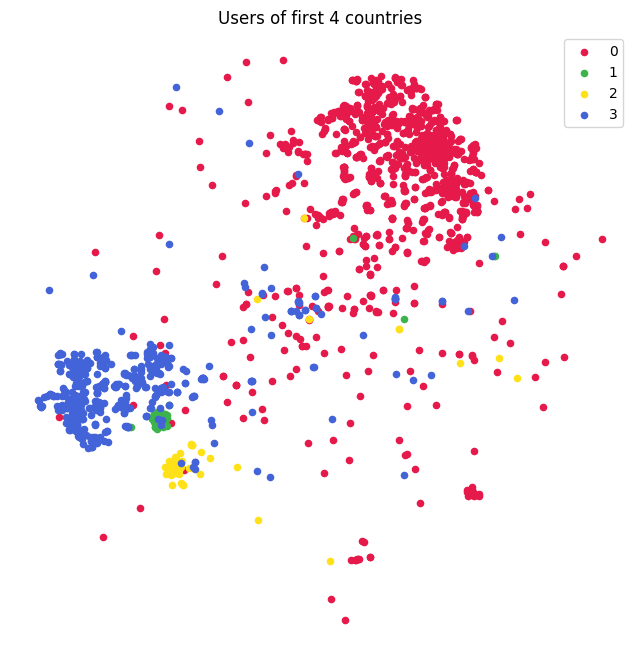

In [69]:
# Visualize the trained embeddding with approach 2
with torch.no_grad():
  model_dw.eval()
  visualize_emb(
      model_dw(torch.arange(G.number_of_nodes(), device=device)).cpu().numpy(),
      G, labels, col_list
  )

Embeddings learnt using this random walk based approach did quite well compared to the previous approach in separating out the users as per their country. Note that the country information was nowhere used during the training.

### Approach 3 based on [Node2Vec](https://arxiv.org/pdf/1607.00653.pdf)

High `p` ensures the walker would be less likely to visit already seen node. 

Less value of `q` implies more inclination to visit nodes further away from source.

DFS kind of approach is suggested as this is a social network type of data where strong homophily based relations are expected. We will explore various choices for the same.

In [70]:
if seed is not None:
  torch.manual_seed(seed)

# p ne 1 or q ne 1 implies Node2Vec. These are the bias parameters to control BFS-DFS combo
# use the positive edges of the pruned graph
model_nv = Node2Vec(pos_edge_index, embedding_dim=64, 
                 walk_length=6,                        # lenght of rw
                 context_size=4, walks_per_node=20,
                 num_negative_samples=1, 
                 p=4, q=0.5,                             # bias parameters
                 sparse=True).to(device)

# Data loader
loader_nv = model_nv.loader(batch_size=108, shuffle=True, num_workers=2)
# Optimizer
optimizer_nv = torch.optim.SparseAdam(list(model_nv.parameters()), lr=0.01)

#### Train
See the learning in action!

In [71]:
for epoch in tqdm(range(1, 151)):
  # get the loss after one epoch
  loss = train(model_nv, loader_nv, optimizer_nv)
  # get the accuracy of prediction
  acc_train, acc_test, train_pred, test_pred = test(
      model_nv, train_label, train_edge, test_edge, test_label
  )
  # show progress
  if epoch % 10 == 0:
    print(f"epoch {epoch:03d}: loss {loss:.6f} train acc {acc_train:.4f} test acc {acc_test:.4f}")

  0%|          | 0/150 [00:00<?, ?it/s]

epoch 010: loss 1.012191 train acc 0.7640 test acc 0.5876
epoch 020: loss 0.795741 train acc 0.9089 test acc 0.7538
epoch 030: loss 0.764458 train acc 0.9502 test acc 0.8223
epoch 040: loss 0.756190 train acc 0.9595 test acc 0.8464
epoch 050: loss 0.754223 train acc 0.9634 test acc 0.8547
epoch 060: loss 0.752643 train acc 0.9628 test acc 0.8541
epoch 070: loss 0.754106 train acc 0.9644 test acc 0.8612
epoch 080: loss 0.753853 train acc 0.9642 test acc 0.8556
epoch 090: loss 0.754736 train acc 0.9637 test acc 0.8531
epoch 100: loss 0.754661 train acc 0.9641 test acc 0.8579
epoch 110: loss 0.755257 train acc 0.9645 test acc 0.8572
epoch 120: loss 0.754234 train acc 0.9641 test acc 0.8595
epoch 130: loss 0.754834 train acc 0.9637 test acc 0.8612
epoch 140: loss 0.754172 train acc 0.9638 test acc 0.8599
epoch 150: loss 0.754665 train acc 0.9636 test acc 0.8601


#### Evaluate performance

In [72]:
# Precision, recall, f1-score on training input after training
precision_recall_fscore_support(
    train_label.numpy(),
    train_pred,
    average = 'binary'
)

(0.9699436950621785, 0.9568049228802046, 0.9633295113954097, None)

In [73]:
# Precision, recall, f1-score on test input after training
precision_recall_fscore_support(
    test_label,
    test_pred,
    average = 'binary'
)

(0.9604415823367065, 0.7510791366906475, 0.8429551877270893, None)

In [74]:
# Train accuracy
print(f"Predicted {sum(train_pred == np.array(train_label))} edges correctly out of {train_pred.shape[0]} edges in train. Accuracy: {sum(train_pred == np.array(train_label))/train_pred.shape[0]:.2%}")
# Test accuracy
print(f"Predicted {sum(test_pred == test_label)} edges correctly out of {test_pred.shape[0]} edges in test. Accuracy: {sum(test_pred == test_label)/test_pred.shape[0]:.2%}")

Predicted 48229 edges correctly out of 50052 edges in train. Accuracy: 96.36%
Predicted 4782 edges correctly out of 5560 edges in test. Accuracy: 86.01%


* As noted above, Node2Vec had a **f1-score of 96% on training** data, **84% on test data**, and on **test data the accuracy is 86%**. It performed similar to DeepWalk.

* Some hyperparameter tuning (#epochs, p, q, walk length, batch size, etc.), or a different optimizer would help probably to get even better results. Note that the loss values seem to hit a plateau in the later epochs.


(7624, 2)


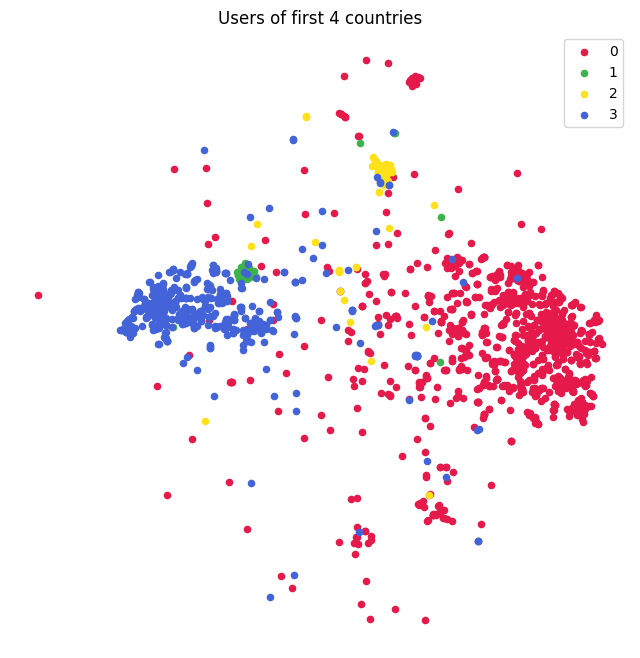

In [75]:
# Visualize the trained embeddding with approach 3
with torch.no_grad():
  model_nv.eval()
  visualize_emb(
      model_nv(torch.arange(G.number_of_nodes(), device=device)).cpu().numpy(),
      G, labels, col_list
  )

Node2Vec based embedding did a bit more better than DeepWalk in terms of identifying clusters of users based on their country. Users from the same country tend to follow each-other - which makes sense as well.

### Summary of node embedding outcome

* In summary, node embedding learnt using **Graph Factorization** approach worked **worse than DeepWalk and Node2Vec for link prediction** in this example.

* But, the Graph Factorization approach was simpler and faster to execute than the others.

* **Random walk based models** performed **way better** than Graph Factorization for **clustering the users** on smaller dimension. It seems Node2Vec did marginally better than DeepWalk in this aspect.

* Note that, Graph Factorization approach updated the embedding weights based on its ability to predict true label of an edge. But, random walk based methods implemented here had not seen the loss in terms of predicting true label of edge, neither of node.


## Link prediction using descriptive metrics

There are a lot of graph data related metrics which can also be used to do the link prediction task. 

For example, [The Link Prediction Problem for Social Networks (2004)](http://www.cs.cornell.edu/home/kleinber/link-pred.pdf) - this paper has reference to metrics like `Jaccards's coefficient`, `Adamic-Adar index`, `rooted PageRank` (same as Personalized PageRank where teleporting to a random node is fixed to the source node itself), `Katz centrality`, etc.

The above referenced paper had mentioned that the `Adamic-Adar index` had perfomed well on average across multiple social network based datasets they explored. We will also test this metric for link prediction.

### Approach

* Figure out the list of nodes in the test set of edges which were removed and the test set of edges which did not exist in original graph.

* Compute `Adamic-Adar index` for each of those nodes with all the nodes present in the graph.

* Sort the score in descending order, the top scored is the predicted link for a given source node.

* Check how many edges are predicted correctly (positive test edge in predicted set, or negative test edge not in predicted set) out of all the edges in test set, that is the accuracy.

In [76]:
print(f"#edges in test set: {test_edge.shape[1]}")
# get the unique list of nodes participating in the removed edges
nodes_removed_edge = list(set([node for edge in edges_removed + neg_edge_list_ts for node in edge]))
print(f"#nodes in test set of edges: {len(nodes_removed_edge)}")

#edges in test set: 5560
#nodes in test set of edges: 5333


In [77]:
# initialize list of predicted edges for the above nodes
edge_pred_list = []

# iterate over each node to find the other node with which it has
# highest adamic-adar index
for u in tqdm(nodes_removed_edge):
  # all possible nodes except the source node
  possible_friends = [v for v in G.nodes() if v != u]
  # concat source with all possible friends
  possible_edges = zip([u] * len(possible_friends), possible_friends)
  # get the index
  aa = nx.adamic_adar_index(G, possible_edges)
  aa_list = [x for x in aa]
  # find the highest indexed item
  highest_aa = sorted(aa_list, key=lambda item: item[2], reverse=True)[:1]
  # fetch the (u,v) pair of highest ranked index
  edge_pred = highest_aa[0][:2]
  # update the list of predicted edges
  edge_pred_list.append(edge_pred)

  0%|          | 0/5333 [00:00<?, ?it/s]

In [78]:
# Check for existence of the predicted edges in the test set of removed edges
correctly_predicted_pos = sum(
    [
        ((pe in edges_removed) or (pe[::-1] in edges_removed))
        and (pe not in neg_edge_list_ts) and (pe[::-1] not in neg_edge_list_ts)
        for pe in edge_pred_list
    ]
)
correctly_predicted_neg = sum(
    [
        (ne not in edge_pred_list) or (ne[::-1] not in edge_pred_list)
        for ne in neg_edge_list_ts
    ]
)
print(f"{correctly_predicted_pos} edges correctly predicted (predicted in test positive) out of {len(edges_removed)} positives in test set, accuracy: {correctly_predicted_pos/len(edges_removed):.2%}")
print(f"{correctly_predicted_pos+correctly_predicted_neg} edges correctly predicted (predicted in test positive and test negative not in predicted) out of {test_edge.shape[1]} in test set, accuracy: {(correctly_predicted_pos+correctly_predicted_neg)/test_edge.shape[1]:.2%}")

319 edges correctly predicted (predicted in test positive) out of 2780 positives in test set, accuracy: 11.47%
3099 edges correctly predicted (predicted in test positive and test negative not in predicted) out of 5560 in test set, accuracy: 55.74%


### Evaluation

* This approach predicted 55.7% edges correctly. Interstingly, it predicted only 11.5% of positive edges correctly, and 100% of negative edges correctly.

* Clearly this approach is lot worse than the random walk based node embedding approaches which had a minimum accuracy of 86%.

* Overall accuracy is comparable with Graph Factorization approach, however that approach was biased towards predicting positive edges, and this one is biased towards predicting negatives.

## Next steps

* Link prediction logic in all the approaches explored above are done assuming we know the potential new edge candidate and we want to check whether that would happen or not. This is different from predicting new edges in future time with respect to the overall graph.

* So far, only the egde information has been used to predict a link in above approaches, but data also exists for node features (artists liked by the user). Graph Neural Network might be utilized to use that information.

* The approaches explored above would not work if a new node comes into the network, as that would require retraining from scratch. Again, Graph Neural Network may overcome this problem as long as the feature dimension does not change.